In [187]:
# imports

from surfacecode.logical_qubit import LQubit
from surfacecode.circuits import SquareLattice
from surfacecode.lattice import *
from surfacecode.simulators import *
from surfacecode.surface import *
from surfacecode.mwpm import ParityCheckMatrix, ErrorCorrection

from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [188]:
WIDTH, HEIGHT = 3, 11
l = (7, 19)

lattice = SquareLattice(WIDTH, HEIGHT)
qubit = LQubit(lattice, l[0], l[1], True)
cycle = SurfaceCodeCycle(lattice)
num_qubits = WIDTH * HEIGHT

# Compose quantum circuit

In [189]:
qc = ConstrainedQuantumCircuit(lattice, WIDTH * HEIGHT)
qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(num_qubits)))

qc.add_register(ClassicalRegister(num_qubits + len(qubit.route(l[0],l[1])) // 2))
qc = qc.compose(qubit.alt_initialize(cycle), list(range(num_qubits)), list(range(num_qubits, 2 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(2 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 3 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc = qc.compose(qubit.circle_gate())

qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(3 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 4 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc.add_register(ClassicalRegister(2))
qc = qc.compose(qubit.alt_measure(), list(range(num_qubits)), list(range(4 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 4 * num_qubits + len(qubit.route(l[0],l[1])) // 2 + 2)))

In [190]:
aersim = AerSimulator(method="stabilizer")
built = transpile(qc, aersim)
job = aersim.run(built, shots =1)
result = job.result()
result.get_counts()

{'10 000000000001000101000100000001000 000000000001000101000100000001000 00000000000100000000000100000100011 000000000001000101000100000001000': 1}

In [191]:
def cycles(key: str, num_stabilizers: int, width: int, height: int):
    cycles = key.split(" ")[1:]
    sep_cycles = []
    for cycle in cycles:
        cycle = cycle[:width * height]
        j = 1
        z_measures = []
        x_measures = []
        for i, measure in enumerate(cycle):
            if i >= width * j:
                j += 1
            if i % 2 == 1:
                if j % 2 == 1:
                    z_measures.append(int(measure))
                else:
                    x_measures.append(int(measure))
                    
        sep_cycle = np.concatenate([np.array(z_measures), np.array(x_measures)])
        sep_cycle = np.array(sep_cycle).reshape(1, -1)
        sep_cycles.append(sep_cycle)

    sep_cycles = np.concatenate(sep_cycles)
    return sep_cycles

'11 000000000001000100010001000000000 000000000001000100010001000000000 00000000000100010000010000000000001 000000000001000100000001000000000'

# Add noise

In [133]:
noise_model = NoiseModel()
error = depolarizing_error(0.3, 1)
noise_model.add_all_qubit_quantum_error(error, ['x', 'z', 'h'])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x', 'z']
  Instructions with noise: ['z', 'h', 'x']
  All-qubits errors: ['x', 'z', 'h']


In [137]:
aersim = AerSimulator(method="stabilizer", noise_model=noise_model)
built = transpile(qc, aersim)
job = aersim.run(built, shots = 10000)
result = job.result()
shots = result.get_counts()
shots

{'10 000001000100000000000001000000000 000101000001000101000101000001000 00010100000000000100010100000100000 000001000000000100000001000001000': 1,
 '00 000100000100000000010001000001010 000100000001000100010001000100000 00000000010000010000010100010000011 000000000100000001000001000100000': 1,
 '10 000001000101000101000101000000000 000100000000000000010101000001000 00010100000000000000010100010100001 000001000000000101000000000100000': 1,
 '01 000100000101000000000000000100000 000000000001000001010001000100000 00010000000000010000010100000000001 000100000001000100000000000100000': 1,
 '11 000000000101000001010000000101000 000001000000000001010000000000000 00000000000000010000000100010000011 000100000100000101000101000100000': 1,
 '00 000001000101000000010101000100010 000101000001000001010001000101000 00010000010000000000010000000100010 000001000001000001000100000101000': 1,
 '11 000001000100000000010001000100010 000101000101000001010001000100000 00000100000100000000000000000000010 000

In [147]:
np.linspace(0, 1, 50)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [203]:
noise_ps = np.linspace(0, 1, 50)
fns, fps, tns, tps = [], [], [], []

for noise_p in tqdm(noise_ps):
    noise_model = NoiseModel()
    error = depolarizing_error(noise_p, 1)
    noise_model.add_all_qubit_quantum_error(error, ['x', 'z', 'h'])

    aersim = AerSimulator(method="stabilizer", noise_model=noise_model)
    built = transpile(qc, aersim)
    job = aersim.run(built, shots = 3000)
    result = job.result()
    shots = result.get_counts()


    fn, fp, tn, tp = 0, 0, 0, 0

    for shot in list(shots.keys()):
        counts = shots[shot]
        a = cycles(shot, lattice.z_counter + lattice.x_counter, WIDTH, HEIGHT)
        parity = ParityCheckMatrix(lattice.z_counter + lattice.x_counter, len(lattice.nodes) - lattice.z_counter - lattice.x_counter)
        mm = parity._populate(lattice)
        correction = ErrorCorrection(parity)
        b = correction.analyze(np.array(list(reversed(a))[2:]))
        if b[5] ^ b[8]:
            a1, b1 = int(shot[0]), int(shot[1])
            x1 = a1 ^ b1
            a2, b2 = int(shot[104]), int(shot[105])
            x2 = a2 ^ b2
            x3 = x1 ^ x2
            if x3:
                fn += counts
            else:
                fp += counts
        else:
            a1, b1 = int(shot[0]), int(shot[1])
            x1 = a1 ^ b1
            a2, b2 = int(shot[104]), int(shot[105])
            x2 = a2 ^ b2
            x3 = x1 ^ x2
            if x3:
                tp += counts
            else:
                tn += counts

    fns.append(fn)
    fps.append(fp)
    tns.append(tn)
    tps.append(tp)



100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


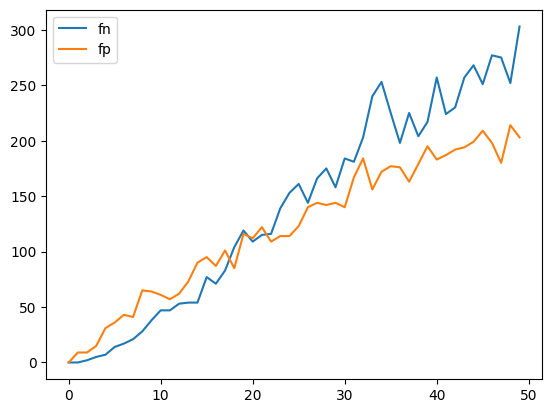

In [204]:
ids = np.arange(0, 50)

plt.plot(ids, fns, label="fn")
plt.plot(ids, fps, label="fp")
plt.legend()

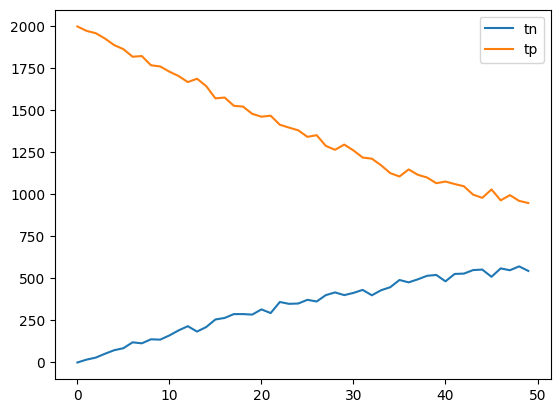

In [205]:
ids = np.arange(0, 50)

plt.plot(ids, tns, label="tn")
plt.plot(ids, tps, label="tp")
plt.legend()

In [186]:
sum(fns) + sum(fps) + sum(tns) + sum(tps)

2989

In [110]:
s = "0000000100010000010101010000000000000010000000100010000010000010100000000000000000000100010000000100001"
len(s)

103

In [56]:
list(shots.keys())[26]

'00 000001000001000101010001000000000 000101000101000001000101000000000 00010100010100000100000000000000000 000001000101000001000000000000000'

In [105]:
a

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]])

In [57]:
lattice.x_counter

10

In [106]:
parity = ParityCheckMatrix(lattice.z_counter + lattice.x_counter, len(lattice.nodes) - lattice.z_counter - lattice.x_counter)
mm = parity._populate(lattice)
correction = ErrorCorrection(parity)

In [107]:
b = correction.analyze(np.array(list(reversed(a))[2:]))

In [102]:
np.array(list(reversed(a))[2:])

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]])

In [108]:
b[:17], b[17:]


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [74]:
c =reversed(a)
list(c)

[array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0])]

In [63]:
b.shape

(74,)

In [64]:
lattice.z_counter + lattice.x_counter

16

In [68]:
lattice.x_counter

10